In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


## 10.1

In [7]:
bank_df = pd.read_csv('D:/숙탯 2기/dmba-datasets/banks.csv')
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

In [8]:
bank_df

,Obs,Financial_Condition,TotCap/Assets,TotExp/Assets,TotLns&Lses/Assets
0,1,1,9.7,0.12,0.65
1,2,1,1.0,0.11,0.62
2,3,1,6.9,0.09,1.02
3,4,1,5.8,0.10,0.67
4,5,1,4.3,0.11,0.69
5,6,1,9.1,0.13,0.74
6,7,1,11.9,0.10,0.79
7,8,1,8.1,0.13,0.63
8,9,1,9.3,0.16,0.72
9,10,1,1.1,0.16,0.57


In [9]:
predictors = ['TotLns&Lses/Assets', 'TotExp/Assets']
outcome = 'Financial_Condition'

y = bank_df[outcome]
X = bank_df[predictors]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -1115.834670153129
             TotLns&Lses/Assets  TotExp/Assets
coefficient         -922.752711   15397.963729

AIC 26.942987497308877


### a.

i. 로짓 = -1115.834670153129 + -922.752711*TotLns&Lses/Assets + 15397.963729*TotExp/Assets

ii. 오즈 = e^로짓

iii. p = 1 / {1+e^(-로짓)} = 오즈/(1+오즈)

### b.

In [17]:
# 로짓
round(-1115.834670153129 + -922.752711*0.6 + 15397.963729*0.11, 4)

24.2897

In [18]:
# 오즈
round(np.exp(-1115.834670153129 + -922.752711*0.6 + 15397.963729*0.11), 4)

35390647839.9497

In [22]:
# 확률
round(np.exp(-1115.834670153129 + -922.752711*0.6 + 15397.963729*0.11) /
      (1 + np.exp(-1115.834670153129 + -922.752711*0.6 + 15397.963729*0.11)), 4)

1.0

확률>0.5이므로 클래스 1에 속함

### c.

In [23]:
# 오즈의 임계값
0.5/(1-0.5)

1.0

In [25]:
# 로짓의 임계값
np.log(1.0)

0.0

### d.

TotLns&Lses/Assets이 한 단위 증가하면 재정적으로 약할 오즈가 e^(-922.752711)만큼 감소한다.

### e.

In [27]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0 1
     0 6 0
     1 0 6
Confusion Matrix (Accuracy 0.3750)

       Prediction
Actual 0 1
     0 3 1
     1 4 0


재정상태가 열악한 은행이 파산할 경우 매우 큰 손실이 발생하므로 재정상태가 열악한 은행에 대한 분류의 정확도를 높여야 오분류 비용이 감소한다.  
따라서 컷오프 값을 증가시켜야 한다.

## 10.2

In [56]:
admst_df = pd.read_csv('D:/숙탯 2기/dmba-datasets/SystemAdministrators.csv')
admst_df.columns = [c.replace(' ', '_') for c in admst_df.columns]
admst_df

,Experience,Training,Completed_task
0,10.9,4,Yes
1,9.9,4,Yes
2,10.4,6,Yes
3,13.7,6,Yes
4,9.4,8,Yes
...,...,...,...
70,5.6,4,No
71,5.9,8,No
72,6.4,6,No
73,3.8,4,No


### a.

<AxesSubplot:xlabel='Experience', ylabel='Training'>

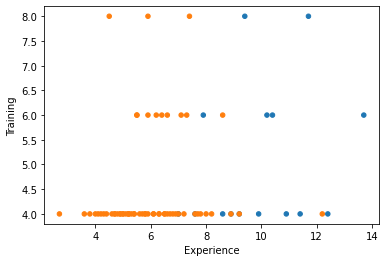

In [33]:
admst_df.plot.scatter(x='Experience', y='Training', c=['C0' if c == 'Yes' else 'C1' for c in admst_df.Completed_task])

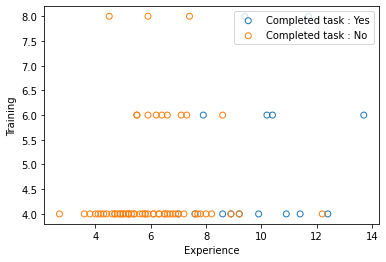

In [57]:
_, ax = plt.subplots()
for completedValue, color in ('Yes', 'C0'), ('No', 'C1'):
    subset_df = admst_df[admst_df.Completed_task == completedValue]
    ax.scatter(subset_df.Experience, subset_df.Training, color='none', edgecolor=color)
ax.set_xlabel('Experience')
ax.set_ylabel('Training')
ax.legend(["Completed task : Yes", "Completed task : No"])

plt.show()

경험이 많을수록 주로 시간 내에 완료하고 경험이 적을수록 대체로 시간 내에 완료하지 못하는 것으로 나타나므로 Experience 변수가 유용하다.  
Training 변수로는 딱히 분류되지 않음.

### b.

In [42]:
change_value_dict = {'No':0, 'Yes':1}
admst_df.replace({'Completed_task':change_value_dict}, inplace=True)

predictors = ['Experience', 'Training']
outcome = 'Completed_task'

X = admst_df[predictors]
y = admst_df[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -15.646119443605366
             Experience  Training
coefficient    1.835234  0.118728

AIC 24.058759202458987


In [43]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9111)

       Prediction
Actual  0  1
     0 31  1
     1  3 10


In [45]:
3/13

0.23076923076923078

약 23% 오분류되었다.

### c.

컷오프값을 증가시켜야 업무를 완료했다고 분류되는 관리자의 비율이 높아진다(=업무 완료 클래스에 대한 오분류율이 감소한다.)

### d.

p > 0.5  
<=> Odds > 1.0  
<=> log(Odds) > 0  
<=> -15.646119443605366 + 1.835234*x + 0.118728 ** 4 > 0

In [47]:
(15.646119443605366 - 0.118728 * 4)/1.835234

8.266633815418288

약 8.3주 이상의 경험이 필요

## 10.3

In [71]:
mowers_df = pd.read_csv('D:/숙탯 2기/dmba-datasets/RidingMowers.csv')
mowers_df

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner
5,110.1,19.2,Owner
6,108.0,17.6,Owner
7,82.8,22.4,Owner
8,69.0,20.0,Owner
9,93.0,20.8,Owner


### a.

In [64]:
mowers_df.groupby('Ownership').size()

Ownership
Nonowner    12
Owner       12
dtype: int64

50%

### b.

In [77]:
mowers_df.Income.mean()

68.4375

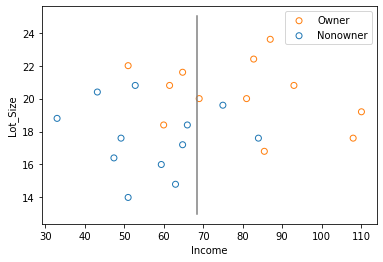

In [76]:
_, ax = plt.subplots()
for ownershipValue, color in ('Owner', 'C1'), ('Nonowner', 'C0'):
    subset_df = mowers_df[mowers_df.Ownership == ownershipValue]
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color='none', edgecolor=color)
ax.set_xlabel('Income')
ax.set_ylabel('Lot_Size')
ax.legend(["Owner", "Nonowner"])
ax.plot((68.4375, 68.4375), (13, 25), color='grey')

plt.show()

대체로 Owner 클래스가 평균소득보다 높은 소득을 가짐.

### c.

In [67]:
change_value_dict = {'Nonowner':0, 'Owner':1}
mowers_df.replace({'Ownership':change_value_dict}, inplace=True)

predictors = ['Income', 'Lot_Size']
outcome = 'Ownership'

X = mowers_df[predictors]
y = mowers_df[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -15.432245020237476
              Income  Lot_Size
coefficient  0.08555  0.510334



ValueError: math domain error

In [68]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.7857)

       Prediction
Actual 0 1
     0 4 2
     1 1 7


4/6 = 2/3 이 정확하게 분류되었음.

### d.

컷오프값을 낮춰야 한다.

### e.

In [78]:
np.exp(-15.432245020237476+0.08555*60+0.510334*20)

0.9115899372432865

### f.

0.9115899372432865 < 1.0 이므로 p < 0.5  
따라서 비소유자로 분류된다.

### g.

-15.432245020237476 + 0.08555x + 0.510334 * 16 > 0

In [81]:
(15.432245020237476 - 0.510334 * 16) / 0.08555

84.94331993264146

약 $84943

## 10.4

In [170]:
auction_df = pd.read_csv('D:/숙탯 2기/dmba-datasets/eBayAuctions.csv')
auction_df

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,Automotive,US,2992,5,Sun,359.95,359.95,0
1968,Automotive,US,21,5,Sat,610.00,300.00,1
1969,Automotive,US,1400,5,Mon,549.00,549.00,0
1970,Automotive,US,57,7,Fri,820.00,650.00,1


#### 데이터 전처리

In [171]:
auction_df.Category = auction_df.Category.astype('category')
auction_df.currency = auction_df.currency.astype('category')
auction_df.endDay = auction_df.endDay.astype('category')
auction_df.Duration = auction_df.Duration.astype('category')

In [172]:
auction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      1972 non-null   category
 1   currency      1972 non-null   category
 2   sellerRating  1972 non-null   int64   
 3   Duration      1972 non-null   category
 4   endDay        1972 non-null   category
 5   ClosePrice    1972 non-null   float64 
 6   OpenPrice     1972 non-null   float64 
 7   Competitive?  1972 non-null   int64   
dtypes: category(4), float64(2), int64(2)
memory usage: 70.9 KB


### a.

In [173]:
auction_df.groupby('Category')['Competitive?'].mean().sort_values()

Category
Health/Beauty           0.171875
EverythingElse          0.235294
Coins/Stamps            0.297297
Pottery/Glass           0.350000
Automotive              0.353933
Jewelry                 0.365854
Books                   0.500000
Clothing/Accessories    0.504202
Toys/Hobbies            0.529915
Antique/Art/Craft       0.564972
Collectibles            0.577406
Music/Movie/Game        0.602978
Home/Garden             0.656863
Computer                0.666667
Business/Industrial     0.666667
SportingGoods           0.725806
Electronics             0.800000
Photography             0.846154
Name: Competitive?, dtype: float64

In [174]:
auction_df.groupby('endDay')['Competitive?'].mean().sort_values()

endDay
Sat    0.427350
Fri    0.466899
Wed    0.480000
Sun    0.485207
Tue    0.532164
Thu    0.603960
Mon    0.673358
Name: Competitive?, dtype: float64

In [175]:
auction_df.groupby('Duration')['Competitive?'].mean().sort_values()

Duration
3     0.450704
7     0.489142
1     0.521739
10    0.544554
5     0.686695
Name: Competitive?, dtype: float64

In [176]:
auction_df.groupby('currency')['Competitive?'].mean().sort_values()

currency
US     0.519350
EUR    0.551595
GBP    0.687075
Name: Competitive?, dtype: float64

In [180]:
auction_red_df = pd.DataFrame({
    'Cat1' : [1 if d in ('Health/Beauty', 'EverythingElse', 'Coins/Stamps', 'Pottery/Glass', 'Automotive', 'Jewelry')
             else 0 for d in auction_df.Category],
    'Cat2' : [1 if d in ('Books', 'Clothing/Accessories', 'Toys/Hobbies', 'Antique/Art/Craft', 'Collectibles',
                         'Music/Movie/Game', 'Home/Garden', 'Computer', 'Business/Industrial') else 0 for d in auction_df.Category],
    'Duration_5' : [1 if d == 5 else 0 for d in auction_df.Duration],
    'GBP' : [1 if d == 'GBP' else 0 for d in auction_df.currency],
    'sellerRating' : auction_df.sellerRating,
    'ClosePrice' : auction_df.ClosePrice,
    'OpenPrice' : auction_df.OpenPrice,
    'Competitive?' : auction_df['Competitive?']})

In [181]:
auction_red_df

,Cat1,Cat2,Duration_5,GBP,sellerRating,ClosePrice,OpenPrice,Competitive?
0,0,1,1,0,3249,0.01,0.01,0
1,0,1,1,0,3249,0.01,0.01,0
2,0,1,1,0,3249,0.01,0.01,0
3,0,1,1,0,3249,0.01,0.01,0
4,0,1,1,0,3249,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,1,0,1,0,2992,359.95,359.95,0
1968,1,0,1,0,21,610.00,300.00,1
1969,1,0,1,0,1400,549.00,549.00,0
1970,1,0,0,0,57,820.00,650.00,1


### b.

In [182]:
auction_red_df.columns

Index(['Cat1', 'Cat2', 'Duration_5', 'GBP', 'sellerRating', 'ClosePrice',
       'OpenPrice', 'Competitive?'],
      dtype='object')

In [183]:
predictors = ['Cat1', 'Cat2', 'Duration_5', 'GBP', 'sellerRating', 'ClosePrice', 'OpenPrice']
outcome = 'Competitive?'

X = auction_red_df[predictors]
y = auction_red_df[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.361700361667707
                 Cat1      Cat2  Duration_5       GBP  sellerRating  \
coefficient -0.982768  0.014132    0.855992  1.158619     -0.000019   

             ClosePrice  OpenPrice  
coefficient    0.075912  -0.089241  

AIC 1142.0142267794981


### c.

In [184]:
predictors = ['Cat1', 'Cat2', 'Duration_5', 'GBP', 'sellerRating', 'OpenPrice']
outcome = 'Competitive?'

X = auction_red_df[predictors]
y = auction_red_df[outcome]


train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  1.1282060560465583
                 Cat1      Cat2  Duration_5       GBP  sellerRating  OpenPrice
coefficient -2.100058 -0.985028    0.855626  0.881061     -0.000027  -0.003219

AIC 1497.3772949583508


### d.

In [187]:
np.exp(0.075912)

1.0788676296283786

경매종가가 0.075912단위 증가하면 경매가 경쟁적으로 분류될 오즈가 1.0788 증가